In [1]:
import json
import os
import numpy as np
from scipy.io import loadmat
import tensorflow as tf
from time import time, sleep
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from model.assembler import get_model_logits


class data_handler:

    def __init__(self, basename, fname_reference='RECORDS',
                 answers='answers.txt'):
        self.basename = basename
        self.fname_reference = fname_reference
        self.answers = answers
        self.processed = set()
        self.processing = None
        self.waiting = set()
        self.last_update = time()
        self.start_time = time()

    def map_label(self, label):

        str2idx = {'N': 0, 'A': 1, 'O': 2, '~': 3}
        idx2str = {v: k for k, v in str2idx.items()}
        if type(label) == str:
            return str2idx[label]
        elif type(label) == int:
            return idx2str[label]

    def t_since_update(self):
        return time() - self.last_update

    def next(self):
        if self.processing is not None: raise ValueError(
            'asked for next sample, while previous was not processed')
        
        if len(self.waiting) > 0:
            record_name = self.waiting.pop()
            fname = os.path.join(self.basename, record_name)
            res = {'name': record_name}
            res.update(loadmat(fname))
            self.processing = record_name
            return res
        return None
    
    def map_logits(self, logits):
        return self.map_label(int(np.argmax(logits)))
    
    def write(self, fname, logits):
        assert fname not in self.waiting
        assert fname not in self.processed
        assert fname == self.processing
        
        print('%1.1f' %self.start_time, sample['name'], 'evaluated to ', 
              dh.map_logits(logits_val))
        with open(self.answers, 'a') as f:
            f.write(fname + ',' + self.map_logits(logits) + '\n')
        self.processing = None
        self.processed.add(fname)
        self.last_update = time()

    def check(self):
        with open('RECORDS') as f:
            fnames = {fn for fn in f.read().split('\n') if len(fn) > 0}

        new_names = fnames - self.processed - self.waiting
        if len(new_names) > 0:
            print('New files (%d) are waiting' % len(new_names))
            self.last_update = time()
            self.waiting.update(new_names)
            return True
        elif len(self.waiting) > 0:
            print('No new file, but (%d) are waiting' % 
                  len(self.waiting))
            return True
        return False

In [3]:
dh = data_handler('data/raw/augmented/')
proto_path = 'test_scripts/small_resnet.json' 
proto_name = os.path.splitext(proto_path)[0]
proto_name = os.path.basename(proto_name)

tf.reset_default_graph()
print('Building computational graph... ')
print('-'*80)
network_params = json.load(open(proto_path))
input_op = tf.placeholder(1, [1, None], 'INPUT') 
seq_len = tf.shape(input_op, name='seq_len')[-1]
logits = get_model_logits(seq_len, input_op, **network_params)[0]
print('-'*80)
print('Computational graph building done!')

print('Loading pretrained parameters...')
sv = tf.train.Supervisor(
    logdir='ckpt/%s/' % proto_name,
)

df = pd.DataFrame(columns=['N', 'A', 'O', '~'])
WAIT_TIME = 2
MAX_TIME = 10
counter = 0
with sv.managed_session() as sess:
    start_time = time()
    t = time() - start_time
    while not sv.should_stop() and dh.t_since_update() < MAX_TIME:
        print('Checking RECORDS:', end='')
        if dh.check():
            while len(dh.waiting) > 0 and counter < 1000:
                sample = dh.next()
                logits_val = sess.run(logits, {input_op: sample['val']})
                counter += 1
                dh.write(sample['name'], logits_val)
        else:
            print('No file to process, waiting %1.1f sec(s)...' % 
                  WAIT_TIME)
            sleep(WAIT_TIME)
        
    print('Max idle time (%d secs) expired, quitting' % MAX_TIME)

Building computational graph... 
--------------------------------------------------------------------------------
Tensor("ResNet/FCN_block_0/Conv0/conv1d/Squeeze:0", shape=(1, ?, 32), dtype=float32)
Tensor("ResNet/FCN_block_0/Conv1/conv1d/Squeeze:0", shape=(1, ?, 32), dtype=float32)

Variable sized windowing -- number of windows: 5
  Dimensions: [batch_size, num_windows, window_size, num_features]
Tensor("sample_division/Reshape:0", shape=(1, 5, ?, 32), dtype=float32)
Local reduce:
Tensor("Mean:0", shape=(1, 5, 32), dtype=float32)

FC--fc
Tensor("classifier/logits/MatMul:0", shape=(1, 4), dtype=float32)
Tensor("classifier/predictions:0", shape=(1, 4), dtype=float32)
--------------------------------------------------------------------------------
Computational graph building done!
Loading pretrained parameters...
INFO:tensorflow:Restoring parameters from ckpt/small_resnet/model.ckpt
Checking RECORDS:New files (8) are waiting
AUG12879 evaluated to  N
AUG17786 evaluated to  A
AUG12999 eva

KeyboardInterrupt: 

In [47]:
truth[preds['name'] == 'A03596']

,name,label
1677,A02785,~


In [4]:
#df = pd.DataFrame(open('answers.txt'), columns=['name', 'label'])
preds = pd.read_csv('answers.txt', names=['name', 'prediction'])
truth = pd.read_csv('data/raw/training2017/TEST.csv', names=['name', 'label'])
#preds.join
merged = preds.sort_values('name').merge(truth.sort_values('name'), on='name')
#preds
merged[merged['prediction'] == merged['label']].count()[0]/merged.count()[0] * 100

/usr/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


nan

In [31]:
with sv.managed_session() as sess:
    res = sess.run('ResNet/FCN_block_0/Conv1/:0')#, {'INPUT:0': np.ones((1,10000))}))

INFO:tensorflow:Restoring parameters from ckpt/small_resnet/model.ckpt


In [42]:
from tensorflow.python import debug as tf_debug
tf_debug.watch_graph
#res[..., :3].mean()

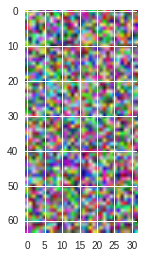

In [8]:
df
#plt.plot(sample['val'].T)

,N,A,O,~
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN
